<a href="https://colab.research.google.com/github/DungDuc/TabSegNet/blob/main/TabSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  #gpu
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, ReLU, Dense
from tensorflow.keras.layers import Add, Multiply, Reshape, DepthwiseConv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.metrics import precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
import cv2


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  #gpu`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
def TabSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=16):
    print('Build TabSegNet: input shape = ', input_shape, '; num_classes = ', num_classes)
    # input
    inputs = Input(shape=input_shape)
    
    # tab detection
    ext_layers = detect_layers - seg_layers
    x_detect   = FeatExtractor(inputs, layers=seg_layers, ext_layers=ext_layers, filters=first_filters)
    
    # detection map
    out_detect = Conv2D(num_classes+1, 3, strides=1, padding='same')(x_detect) # foreground and background
    out_detect = Activation('softmax', name="y_detect")(out_detect)
    
    # tab segmentation
    x_seg = FeatExtractor(inputs, layers=seg_layers, ext_layers=0, filters=first_filters)

    # fusion of detection and segmentation maps
    x_detect = UpScaling(x_detect, 2)
    x = Concatenate()([x_detect, x_seg])
    x = Encode(x, first_filters, stride=1, nConvs=2)
    out_seg = Conv2D(2*num_classes+1, 3, strides=1, padding='same')(x) # (table + border) + background

    # final segmentation map
    out_seg = UpScaling(out_seg, 2**seg_layers)
    out_seg = Activation('softmax', name="y_seg")(out_seg)
    
    return Model(inputs=inputs, outputs=[out_seg, out_detect])

def FeatExtractor(x, layers=3, ext_layers=0, filters=16, pool_max=True):
    # convolutional blocks
    for i in range(layers):
        if i < layers-1 or ext_layers > 0: # not the last block
            x = Encode(x, filters, kernel_size=3, stride=1, nConvs=2)
        else: # last block, using three types of kernels
            x0 = Encode(x, filters//2, kernel_size=(3,3), stride=1, nConvs=2)
            x1 = Encode(x, filters//2, kernel_size=(7,3), stride=1, nConvs=2)
            x2 = Encode(x, filters//2, kernel_size=(3,7), stride=1, nConvs=2)
            x  = Concatenate()([x0, x1, x2])
            x  = Encode(x, filters, kernel_size=(1,1), stride=1, nConvs=1)
        if pool_max:
          x = MaxPooling2D()(x)
        else:
          x = AveragePooling2D()(x)
        filters *= 2 # double number of filters
    
    # extra layers
    if ext_layers > 0:
        ExtFeats = []
        x0 = x
        for i in range(ext_layers):
            x1 = Encode(x0, filters//2, kernel_size=(7,3), stride=1, nConvs=2)
            x2 = Encode(x0, filters//2, kernel_size=(3,7), stride=1, nConvs=2)
            x0 = Encode(x0, filters//2, kernel_size=(3,3), stride=1, nConvs=2)
            x0  = Concatenate()([x0, x1, x2])
            x0  = Encode(x0, filters, kernel_size=(1,1), stride=1, nConvs=1)
            if pool_max:
              x0 = MaxPooling2D()(x0)
            else:
              x0 = AveragePooling2D()(x0)
            if i == 0:
              ExtFeats.append(x0)
            else:
              ExtFeats.append(UpScaling(x0, 2**i))
        # concate features
        x = Concatenate()(ExtFeats)
        x = Encode(x, filters, kernel_size=(1,1), stride=1, nConvs=1)
    
    return x

# Encoder
def Encode(x, filters, kernel_size=3, stride=2, nConvs=2):
    # first conv
    x = Conv_BN_Act(filters, kernel_size=kernel_size, stride=stride)(x) # using input stride
    # stride-1 convs
    for i in range(1, nConvs):
      x = Conv_BN_Act(filters, kernel_size=kernel_size, stride=1)(x) # stride 1
    
    return x

# Convolution block, using batch/instance normalization
def Conv_BN_Act(filters, kernel_size=3, stride=1):
    out = Sequential()
    # conv
    out.add(Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False))
    # norm
    if NormType.lower() == 'batch':
        out.add(BatchNormalization())
    elif NormType.lower() == 'instance':
        out.add(InstanceNormalization())
    # activation
    out.add(ReLU())
    # drop
    if DropRate > 0.0:
        out.add(Dropout(DropRate))
    
    return out

def UpScaling(x,scale):
    x = tf.keras.layers.UpSampling2D(size=[scale,  scale], interpolation='bilinear')(x)
    return x

class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


In [ ]:
# test TabSegNet
num_classes = 1 # table detection
input_shape = [768, 640, 1]
#NormType = 'batch'
NormType = 'instance'
DropRate = 0.2

model = TabSegNet(input_shape, num_classes, first_filters=32)

model.summary()
#tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

In [5]:
# API
def LoadH5Folders(DataFolders):
    X, Y = [], []
    for folder in DataFolders:
      h5Files = glob.glob(folder + '/*.h5')
      for fn in h5Files:
        x, y = LoadFileH5(fn)
        if x is not None:
            X.append(x)
            Y.append(y)
      
    if len(X) > 0:
      X = np.vstack(X)
      Y = np.vstack(Y)
    
    return X, Y

def LoadFileH5(h5File):
    print(h5File)
    with h5py.File(h5File, 'r') as f:
        x = f['input'][:]
        y = f['output'][:]
        return x, y
    return None, None

AllTags = ['Reg1', 'Reg2', 'Reg3',\
        'Reg4', 'Reg5', 'Reg6',\
        'Reg7', 'Reg8', 'Reg9']

Colors = [[255,0,0], [0,255,0], [0,0,255],\
          [255,255,0], [255,0,255], [0,255,255],\
          [128,0,0], [0,128,0], [0,0,128],\
          [255,255,255]]


def set_label(Tags):
    # class name and colors
    nColor = len(Colors)
    for i in range(len(Tags)):
        class_names.append(Tags[i])
        label_values.append(Colors[i%nColor])
    # background
    class_names.append('Background')
    label_values.append([255,255,255])

class_names, label_values = [],[]
set_label(AllTags)    

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1).astype(np.uint16)
    return x
    
def colour_code_segmentation(image):
    colour_codes = np.array(label_values).astype(np.uint8)
    x = colour_codes[image.astype(np.uint16)]
    return x

def ViewImgs(Imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(Imgs)):
        plt.subplot(1, len(Imgs), i+1)
        if Imgs[i].ndim == 3:
            if  Imgs[i].shape[-1] == 3:
              plt.imshow(Imgs[i])
            else:
              plt.imshow(Imgs[i][...,0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(Imgs[i], cmap='gray', vmin=0, vmax=255)
    plt.show()
    
LogFolder = 'gdrive/My Drive/Logs'
CkptFolder = 'gdrive/My Drive/Ckpt'
def CkptName(ModelName):
    return CkptFolder + '/' + ModelName + '.ckpt'
def LogName():
    return LogFolder + '/' + ModelName + '.log'

In [6]:
# data
ICDAR19_Train = 'gdrive/My Drive/Data/ICDAR19/Train'
ICDAR19_Test  = 'gdrive/My Drive/Data/ICDAR19/Test'

ICDAR13_Train = 'gdrive/My Drive/Data/ICDAR13/Train'
ICDAR13_Test  = 'gdrive/My Drive/Data/ICDAR13/Test'

CascadeTableNet = 'gdrive/My Drive/Data/TableDetect/CascadeTableNet'

# ICDAR19 model
XTrain, YTrain = LoadH5Folders([ICDAR19_Train]) 
XTest,  YTest  = LoadH5Folders([ICDAR19_Test])
# ICDAR19+ model
#XTrain, YTrain = LoadH5Folders([ICDAR19_Train, MARMOT_E, MARMOT_C, TableDetect_Train, TableDetect_Test])
#XTest,  YTest  = LoadH5Folders([ICDAR19_Test])
# ICDAR13+ model
#XTrain, YTrain = LoadH5Folders([ICDAR13_Train, ICDAR19_Train, MARMOT_E, MARMOT_C, TableDetect_Train, TableDetect_Test])
#XTest,  YTest  = LoadH5Folders([ICDAR13_Test])

print('XTrain: ', XTrain.shape, '; YTrain: ', YTrain.shape)
print('XTest:  ', XTest.shape,  '; YTest:  ', YTest.shape)


gdrive/My Drive/Data/ICDAR19/Train/ICDAR19_Class_2_Feats_3_0.h5
gdrive/My Drive/Data/ICDAR19/Train/ICDAR19_Class_2_Feats_3_1.h5
gdrive/My Drive/Data/ICDAR19/Train/ICDAR19_Class_2_Feats_3_2.h5
gdrive/My Drive/Data/ICDAR19/Train/ICDAR19_Class_2_Feats_3_3.h5
gdrive/My Drive/Data/ICDAR19/Train/ICDAR19_Class_2_Feats_3_4.h5
gdrive/My Drive/Data/ICDAR19/Test/ICDAR19_Class_2_Feats_3_0.h5
gdrive/My Drive/Data/ICDAR19/Test/ICDAR19_Class_2_Feats_3_1.h5
XTrain:  (600, 768, 640, 3) ; YTrain:  (600, 768, 640)
XTest:   (240, 768, 640, 3) ; YTest:   (240, 768, 640)


In [ ]:
# view data
set_label(AllTags)
id = 0
x, y = XTrain[id], YTrain[id]
y_img = colour_code_segmentation(y)
ViewImgs([x, y_img])

In [7]:
# input data - grayscale image
def FeatImg(ImgIn):
  gray = cv2.cvtColor(ImgIn, cv2.COLOR_RGB2GRAY)
  return np.stack([gray], axis=-1)


In [8]:
XTrain = np.stack([FeatImg(x) for x in XTrain])
XTest = np.stack([FeatImg(x) for x in XTest])
print('Train: ', XTrain.shape, YTrain.shape)
print('Test:  ', XTrain.shape, YTrain.shape)


Train:  (600, 768, 640, 1) (600, 768, 640)
Test:   (600, 768, 640, 1) (600, 768, 640)


In [9]:
# data normalization
Norm = lambda x: np.float32(x)/255.0

# label augmentation
def LabelAug(y, margin=16):
    # select foreground
    y0 = ((y==0)*255).astype('uint8')
    
    # border class construction
    kernel = np.ones((margin,margin),np.uint8)
    y_center = cv2.erode(y0,kernel)
    y_extend = cv2.dilate(y0,kernel)

    y_seg = np.stack([y_center, y_extend-y_center, 255-y_extend], axis=-1)
    y_detect = np.stack([y_extend, 255-y_extend], axis=-1)

    return y_seg, y_detect

# data augmentation
bAugFlip = False
bAugScale = True

def DataAug(x, y):
  # flip
  if bAugFlip and np.random.randint(0,2):
    x, y = ImgFlip(x,y)
  # scale
  if bAugScale and np.random.randint(0,2):
    x, y = ImgScale(x,y)
  return x, y

def ImgFlip(x0,y0):
  return np.fliplr(x0), np.fliplr(y0)

def ImgScale(x0,y0):
  scale = 0.75 + np.random.sample() / 2.5
  if 0.95 < scale < 1.05:
    return x0, y0 # do nothing

  h,w = x0.shape[0:2]
  h1,w1 = h,w
  if np.random.randint(0,2):
    h1 = int(h*scale)
  else:
    w1 = int(w*scale)
  
  x1 = cv2.resize(x0, (w1,h1))
  y1 = ((y0==0)*255).astype('uint8')
  y1 = cv2.resize(y1, (w1,h1)).astype('uint8')
  
  if scale < 1:
    dh,dw = (h - h1)//2,(w - w1)//2
    x2 = cv2.copyMakeBorder(x1, dh, h-h1-dh, dw, w-w1-dw, cv2.BORDER_REFLECT)
    y2 = cv2.copyMakeBorder(y1, dh, h-h1-dh, dw, w-w1-dw, cv2.BORDER_REFLECT)
  else:
    dh,dw = (h1 - h)//2,(w1 - w)//2
    x2 = x1[dh:h+dh,dw:w+dw,...]
    y2 = y1[dh:h+dh,dw:w+dw,...]
  
  y3 = (y2!=255).astype('uint8')
  
  if x2.ndim < x0.ndim:
    x2 = np.expand_dims(x2, axis=-1)

  return x2, y3


In [ ]:
# view augmented data
id = 0
x, y = XTrain[id], YTrain[id]
y_seg, y_detect = LabelAug(y)
ViewImgs([x, y_seg, y_detect])

In [10]:
# build TabSegNet
nDataTest, IMG_H, IMG_W, IMG_C = XTrain.shape
input_shape = [IMG_H, IMG_W, IMG_C]
num_classes = np.max(YTest)

# model config
NormType = 'instance'
DropRate = 0.2

#Opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
Opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#Loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
Losses = {
	"y_seg": "categorical_crossentropy",
	"y_detect": "categorical_crossentropy",
}
lossWeights = {"y_seg": 1.0, "y_detect": 1.0}

model = TabSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=32)

model.compile(optimizer=Opt, loss=Losses, loss_weights=lossWeights, metrics=['accuracy'])
#model.summary()
#tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

Build TabSegNet: input shape =  [768, 640, 1] ; num_classes =  1


In [22]:
# test TabSegNet
def Test(model, X, Y, nClass=1, thresh=0.6):
    print("Testing...")
    (nData, IMG_H, IMG_W, nFeat) = X.shape
    
    ACC, F1, IOU = 0.0, 0.0, 0.0
    nPositive = np.zeros(nClass)
    nPredicted = np.zeros(nClass)
    nTruePos = np.zeros(nClass)
    count = 0
    for i in range(nData):
        # data
        x, y = X[i], Y[i]
        x0 = x
        x = Norm(x)
        x = np.expand_dims(x, axis=0)
        y_seg, y_detect = LabelAug(y)
        # predict
        yy_seg, yy_detect = model.predict(x)
        yy_seg = yy_seg[0]
        yy_detect = yy_detect[0]
    
        # pixel_level performance
        label_code  = reverse_one_hot(y_seg)
        output_code = reverse_one_hot(yy_seg)
        accuracy, class_accuracies, prec, rec, f1, iou = evaluate_segmentation(pred=output_code, label=label_code, num_classes=nClass)
        ACC += accuracy
        F1 += f1
        IOU += iou
        count += 1

        # detection performance
        GTRegions = GetRegionsGT(y, nClass)
        PDRegions = GetRegionsPD(yy_seg[...,0], yy_seg[...,1]) # one-class detection
        TPRegs, nPos, nPred, nTP = MatchRegs(GTRegions, PDRegions, nClass, thresh)
        print(i, nPos, nPred, nTP)
        
        nPositive += nPos
        nPredicted += nPred
        nTruePos += nTP
        # inspect result
        if nTP[0] != nPos[0] or nTP[0] != nPred[0]:
          label_img  = colour_code_segmentation(label_code)
          output_img = colour_code_segmentation(output_code)          
          img = cv2.cvtColor(x0, cv2.COLOR_GRAY2RGB)
          for rg in GTRegions:
            cv2.rectangle(img, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (0, 0, 255), 5)
          for rg in PDRegions:
            cv2.rectangle(img, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (255, 0, 0), 2)
          ViewImgs([img, label_img, output_img])

    # end of for
    if count > 0:
        print('Accuracy, F1, IOU: ', ACC/count, F1/count, IOU/count)
        print(nPositive, nPredicted, nTruePos)
        
        Recall = nTruePos/nPositive
        Precision = nTruePos/nPredicted
        F1  = []
        for i in range(len(Precision)):
          F1.append(2*Precision[i]*Recall[i]/(Precision[i] + Recall[i]) if Precision[i] + Recall[i] > 0 else 0)
        
        print("Class: Recall, Precision, F1")
        for i in range(nClass):
            print("%s: %.4f, %.4f, %.4f" % (class_names[i], Recall[i], Precision[i], F1[i]))

# segmentation evaluation
def evaluate_segmentation(pred, label, num_classes, score_averaging="weighted"):
    flat_pred = pred.flatten()
    flat_label = label.flatten()
    
    global_accuracy = compute_global_accuracy(flat_pred, flat_label)
    class_accuracies = compute_class_accuracies(flat_pred, flat_label, 2*num_classes+1)

    prec = precision_score(flat_pred, flat_label, average=score_averaging)
    rec = recall_score(flat_pred, flat_label, average=score_averaging)
    f1 = f1_score(flat_pred, flat_label, average=score_averaging)

    iou = compute_mean_iou(flat_pred, flat_label)

    return global_accuracy, class_accuracies, prec, rec, f1, iou

# Compute the average segmentation accuracy across all classes
def compute_global_accuracy(pred, label):
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

# Compute the class-specific segmentation accuracy
def compute_class_accuracies(pred, label, num_classes):
    total = []
    for val in range(num_classes):
        total.append((label == val).sum())

    count = [0.0] * num_classes
    for i in range(len(label)):
        if pred[i] == label[i]:
            count[int(pred[i])] = count[int(pred[i])] + 1.0

    # If there are no pixels from a certain class in the GT, 
    # it returns NAN because of divide by zero
    # Replace the nans with a 1.0.
    accuracies = []
    for i in range(len(total)):
        if total[i] == 0:
            accuracies.append(1.0)
        else:
            accuracies.append(count[i] / total[i])

    return accuracies


def compute_mean_iou(pred, label):
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels);
    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val
        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))

    mean_iou = np.mean(I / U)
    return mean_iou

# detection evaluation
class Region(object):
    def __init__(self, tag = None, xmin=None, ymin=None, xmax=None, ymax=None, poly=None):
        self.tag = tag
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.poly = poly
    def iou(self, other):
        if self.poly is not None and other.poly is not None:
            return poly_iou(self.poly, other.poly)
        else:
            return 0
# match regions 
def MatchRegs(GTRegs, PDRegs, nClass, thresh):
  TPRegs = []
  for reg in PDRegs:
    if Match(reg, GTRegs, thresh):
      TPRegs.append(reg)
  
  nPos = np.zeros(nClass)
  nPD = np.zeros(nClass)
  nTP = np.zeros(nClass)
  for i in range(nClass):
    nPos[i] = len([r for r in GTRegs if int(r.tag) == i])
    nPD[i]  = len([r for r in PDRegs if int(r.tag) == i])
    nTP[i]  = len([r for r in TPRegs if int(r.tag) == i])

  return TPRegs, nPos, nPD, nTP

def Match(rg, Regs, thresh):
  for reg in Regs:
    if rg.tag == reg.tag and bb_iou(rg, reg) >= thresh:
      return True
  return False

def bb_iou(regA, regB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(regA.xmin, regB.xmin)
	yA = max(regA.ymin, regB.ymin)
	xB = min(regA.xmax, regB.xmax)
	yB = min(regA.ymax, regB.ymax)
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (regA.xmax - regA.xmin + 1) * (regA.ymax - regA.ymin + 1)
	boxBArea = (regB.xmax - regB.xmin + 1) * (regB.ymax - regB.ymin + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

def poly_iou(tbl1, tbl2):
  tbl1 = np.squeeze(tbl1)
  tbl2 = np.squeeze(tbl2)
  a = Polygon(tbl1)
  b = Polygon(tbl2)
  if a.is_valid and b.is_valid:
    return a.intersection(b).area / a.union(b).area
  else:
    return 0

# ground truth regions
def GetRegionsGT(CodeImg, nClass):
  regions = []
  for i in range(nClass):
    reg_img = np.uint8((CodeImg == i))*255
    contours, _ = cv2.findContours(reg_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
      (x,y,w,h) = cv2.boundingRect(cnt)
      regions.append(Region(str(i), x, y, x+w, y+h, cnt))
  
  return regions

# predicted regions
def GetRegionsPD(yy, yy_border):
    yy  = np.uint8(yy*255)
    yy_border = np.uint8(yy_border*255)
    # global thresholding
    ret1, region_bw = cv2.threshold(yy,127,255,cv2.THRESH_BINARY)
    ret2, border_bw = cv2.threshold(yy_border,127,255,cv2.THRESH_BINARY)
    
    # smoothing
    kernel = np.ones((8,8),np.uint8)
    region_bw = cv2.morphologyEx(region_bw, cv2.MORPH_OPEN, kernel)
    border_bw = cv2.morphologyEx(border_bw, cv2.MORPH_CLOSE, kernel)
    
    # find regions
    regions = []
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(region_bw)
    img_h, img_w = region_bw.shape[0], region_bw.shape[1]
    for i in range(1,nlabels):
        l, t = stats[i,cv2.CC_STAT_LEFT], stats[i,cv2.CC_STAT_TOP]
        w, h = stats[i,cv2.CC_STAT_WIDTH], stats[i,cv2.CC_STAT_HEIGHT]
        r, b = l+w, t+h
 
        # check and get sub-regions
        if w > 100 and h > 8 and stats[i,cv2.CC_STAT_AREA] > 0.6*w*h:
            HRegs = SubRegions(l,t,r,b, region_bw, border_bw, Horiz=True)
            for reg in HRegs:
              VRegs = SubRegions(reg.xmin, reg.ymin, reg.xmax, reg.ymax, region_bw, border_bw, Horiz=False)
              regions.extend(VRegs)

    return regions

# split regions
def SubRegions(left,top,right,bottom, region_bw, border_bw, Horiz=True, thresh_r=0.8, thresh_b=0.6):
    # extended region
    img_h, img_w = region_bw.shape[0], region_bw.shape[1]
    m = 16
    if Horiz:
      top, bottom = max(0, top-m), min(img_h, bottom+m)
    else:
      left, right = max(0, left-m), min(img_w, right+m)
    width, height = right-left, bottom-top
    # region mask
    mask = np.zeros((img_h, img_w), dtype='uint8')
    mask[top:bottom, left:right] = 1
    region = region_bw*mask
    border = border_bw*mask
    #ViewImgs([region_bw, border_bw, region, border])

    # histogram
    if Horiz:
      RegHist = np.sum(region//255,axis=1).tolist()
      BorderHist = np.sum(border//255,axis=1).tolist()
    else:
      RegHist = np.sum(region//255,axis=0).tolist()
      BorderHist = np.sum(border//255,axis=0).tolist()
    #plt.plot(RegHist)
    #plt.show()

    # get regions
    regs = []
    if Horiz:
      PosMin, PosMax = top, bottom
      thresh_r = thresh_r*width
      thresh_b = thresh_b*width
    else:
      PosMin, PosMax = left, right
      thresh_r = thresh_r*height
      thresh_b = thresh_b*height

    pos = PosMin
    while pos < PosMax:
      # left/top border
      while pos < PosMax and BorderHist[pos] < thresh_b:
        pos += 1
      while pos < PosMax and BorderHist[pos] >= thresh_b:
        pos += 1
      if pos >= PosMax:
        break
      Pos1 = pos

      # right/bottom border
      while pos < PosMax and BorderHist[pos] < thresh_b:
        pos += 1
      if pos >= PosMax:
        break
      Pos2 = pos-1
      
      # get region
      if Pos2-Pos1 > m/2 and max(RegHist[Pos1:Pos2]) > thresh_r:
        if Horiz:
          reg = Region(str(0), left, Pos1, right, Pos2, None)
        else:
          reg = Region(str(0), Pos1-m//2, top-m//2, Pos2+m//2, bottom+m//2, None)
        regs.append(reg)
    
    return regs

# visualize region evaluation
def TestEval(model, x, y, nClass, thresh=0.6):
    x0 = x
    x = Norm(x)
    x = np.expand_dims(x, axis=0)
    y_seg, y_detect = LabelAug(y)
    # predict
    yy_seg, yy_detect = model.predict(x)
    yy_seg, yy_detect = yy_seg[0], yy_detect[0]
 
    # pixel performance
    label_code  = reverse_one_hot(y_seg)
    output_code = reverse_one_hot(yy_seg)
    label_img  = colour_code_segmentation(label_code)
    output_img = colour_code_segmentation(output_code)
    accuracy, class_accuracies, prec, rec, f1, iou = evaluate_segmentation(pred=output_code, label=label_code, num_classes=nClass)
    print('IOU: ', iou)

    # detection performance
    GTRegions = GetRegionsGT(y, nClass)
    PDRegions = GetRegionsPD(yy_seg[...,0], yy_seg[...,1])
    TPRegs, nPos, nPred, nTP = MatchRegs(GTRegions, PDRegions, nClass, thresh)
    print('nPos, nPred, nTP:')
    print(nPos, nPred, nTP)

    label_values[2] = [255,255,255]
    ViewImgs([x0, label_img, output_img])


In [12]:
ModelPath = 'gdrive/My Drive/Models'
ModelName = 'ICDAR19Plus'
#ModelName = 'ICDAR19'
#ModelName = 'ICDAR13Plus'
model.load_weights(ModelPath + '/' + ModelName + '.ckpt')


IOU:  0.9086948475233716
nPos, nPred, nTP:
[2.] [2.] [2.]


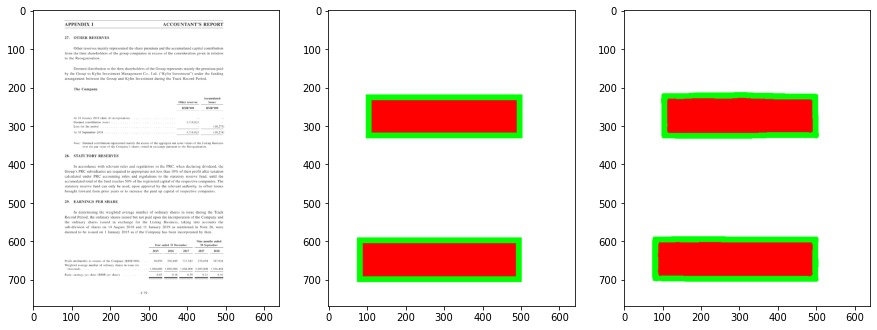

In [21]:
id = 0
TestEval(model, XTest[id], YTest[id], num_classes, thresh=0.6)

In [ ]:
# load the model
ModelPath = 'gdrive/My Drive/Models'
#ModelName = 'ICDAR19Plus'
ModelName = 'ICDAR19'
#ModelName = 'ICDAR13Plus'
model.load_weights(ModelPath + '/' + ModelName + '.ckpt')

# load the test data
ICDAR19_Test  = 'gdrive/My Drive/Data/ICDAR19/Test'
ICDAR13_Test  = 'gdrive/My Drive/Data/ICDAR13/Test'

if ModelName == 'ICDAR19Plus' or ModelName == 'ICDAR19Plus':
  XTest,  YTest  = LoadH5Folders([ICDAR19_Test])
  XTest = np.stack([FeatImg(x) for x in XTest])
elif ModelName == 'ICDAR13Plus':
  XTest,  YTest  = LoadH5Folders([ICDAR13_Test])
  XTest = np.stack([FeatImg(x) for x in XTest])

# test
Test(model, XTest, YTest, nClass=1, thresh=0.6)


In [ ]:
# test the model with different IoU threshold
Test(model, XTest, YTest, num_classes, thresh=0.9)

In [42]:
# data generation for training
def DataGen(X, Y, detect_scale=4, size=1, AugFunt=None):
    nData, h, w = X.shape[0], X.shape[1], X.shape[2]
    scale = 2 ** detect_scale
    ids = np.random.permutation(nData)
    i = 0
    while True:
        # permute data
        if i + size > nData:
            ids = np.random.permutation(nData)
            i = 0
        # select data
        bx, by_seg, by_detect = [], [], []
        for j in range(size):
            x, y = X[ids[i + j]], Y[ids[i + j]]
            if AugFunt:
                x, y = AugFunt(x, y)
            bx.append(x)
            y_seg, y_detect = LabelAug(y)
            by_seg.append(y_seg)
            by_detect.append(y_detect)

        # batch
        bx, by_seg, by_detect = np.asarray(bx), np.asarray(by_seg), np.asarray(by_detect)
        by_detect = tf.image.resize(by_detect, (h // scale, w // scale))
        i += size

        # normalize data
        bx = Norm(bx)
        by_seg = Norm(by_seg)
        by_detect = Norm(by_detect)

        yield (bx, {'y_seg': by_seg, 'y_detect': by_detect})

# train
def Train(XTrain, YTrain, XTest, YTest, ModelName):
    # data infor
    nDataTrain, IMG_H, IMG_W, IMG_C = XTrain.shape
    nDataTest = XTest.shape[0]
    input_shape = [IMG_H, IMG_W, IMG_C]
    num_classes = np.max(YTrain)

    print('Train : ', XTrain.shape,  YTrain.shape)
    print('Test : ', XTest.shape,  YTest.shape)
    print('number of classes: ', num_classes)

    # build the model
    NormType = 'instance'
    DropRate = 0.2

    Opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    #Opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    Losses = {
      "y_seg": "categorical_crossentropy",
      "y_detect": "categorical_crossentropy",
    }
    lossWeights = {"y_seg": 1.0, "y_detect": 1.0}

    model = TabSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=32)
    model.compile(optimizer=Opt, loss=Losses, loss_weights=lossWeights, metrics=['accuracy'])

    # train parameters
    EPOCHS = 50
    BATCH_SIZE = 2
    TrainSteps = nDataTrain // BATCH_SIZE

    # train data augmentation
    bAugFlip = False
    bAugScale = True

    Checkpoint = ModelCheckpoint(ModelName, monitor='val_y_seg_accuracy', mode='max', save_weights_only=True,
                                 save_best_only=True, verbose=0)
    CallBacks = [Checkpoint]
    
    # train
    H = model.fit(DataGen(XTrain, YTrain, detect_scale=4, size=BATCH_SIZE, AugFunt=DataAug),
                  steps_per_epoch=TrainSteps, epochs=EPOCHS,
                  validation_data=DataGen(XTest, YTest, detect_scale=4, size=1),
                  validation_steps=nDataTest, validation_freq=1,
                  callbacks=CallBacks)

    # train log
    acc = H.history['y_seg_accuracy']
    val_acc = H.history['val_y_seg_accuracy']
    loss = H.history['y_seg_loss']
    val_loss = H.history['val_y_seg_loss']
    # save log
    np.savetxt(ModelName+'.log', [loss, val_loss, acc, val_acc])

    # detection test
    Test(model, XTest, YTest, num_classes, thresh=0.6)

In [ ]:
# train TabSegNet models
ModelPath = 'gdrive/My Drive/Models'
ModelName = 'ICDAR19'
#ModelName = 'ICDAR19Plus'
#ModelName = 'ICDAR13Plus'
ModelCkpt = ModelPath + '/' + ModelName + '.ckpt'

# train and test data
ICDAR19_Train = 'gdrive/My Drive/Data/ICDAR19/Train'
ICDAR19_Test  = 'gdrive/My Drive/Data/ICDAR19/Test'

ICDAR13_Train = 'gdrive/My Drive/Data/ICDAR13/Train'
ICDAR13_Test  = 'gdrive/My Drive/Data/ICDAR13/Test'

CascadeTableNet = 'gdrive/My Drive/Data/TableDetect/CascadeTableNet'

# TabSegNet models
if ModelName == 'ICDAR19':
    XTrain, YTrain = LoadH5Folders([ICDAR19_Train])
    XTest,  YTest  = LoadH5Folders([ICDAR19_Test])
elif ModelName == 'ICDAR19Plus':
    XTrain, YTrain = LoadH5Folders([CascadeTableNet])
    XTest,  YTest  = LoadH5Folders([ICDAR19_Test])
elif ModelName == 'ICDAR13Plus':
    XTrain, YTrain = LoadH5Folders([ICDAR13_Train, CascadeTableNet])
    XTest,  YTest  = LoadH5Folders([ICDAR13_Test])

XTrain = np.stack([FeatImg(x) for x in XTrain])
XTest  = np.stack([FeatImg(x) for x in XTest])

# train
Train(XTrain, YTrain, XTest, YTest, ModelName)
